## clustering with `hdbscan`


In [1]:
!pip install hdbscan seaborn

You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.7.9/envs/hcvectors/bin/python3.7 -m pip install --upgrade pip' command.


In [51]:
%load_ext autoreload
%autoreload 2

import time

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import utils

def paginate_list(l, page_size):
    return (l[i : i + page_size] for i in range(0, len(l), page_size))

ENTITY_LABEL_MAPPING = dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load embeddings matrix using KGEmbeddingStore class
emb_store = utils.load_embedding_store()
X = emb_store.ent_embedding_matrix
dim = X.shape[1]

X.shape

(645565, 800)

In [4]:
# load UMAP projections
umap_projection_path = "../../data/processed/final_model_dglke/umap/best_projection_n_neighbours_10.npy"
umap_data = np.load(umap_projection_path)

umap_data.shape

(645565, 2)

## 1. fit clusterer

TODO: loop through sets of parameters. See [here](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)

In [17]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,
)

start = time.time()
clusterer.fit(umap_data)
end = time.time()

print(f"completed in {int(end-start)}s")
print(f"there are {len(np.unique(clusterer.labels_))-1} clusters")

completed in 22s
there are 492 clusters


In [27]:
labels = clusterer.labels_
probabilities = clusterer.probabilities_

## 2. inspect clusters

### 2.1 cluster size distribution

/Users/kalyan/.pyenv/versions/3.7.9/envs/hcvectors/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


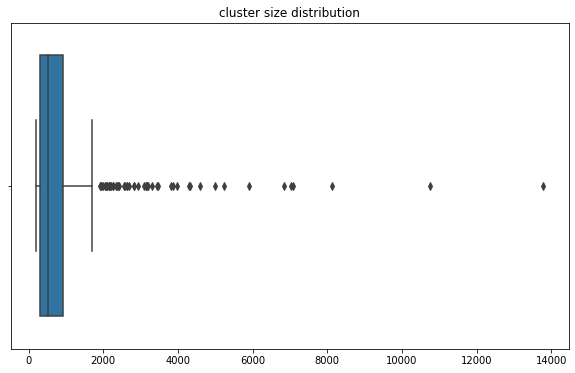

In [28]:
fig, axs = plt.subplots(figsize=(10,6))

labels_clustered = labels[np.where(labels > 0)]
unique, counts = np.unique(labels_clustered, return_counts=True)
sns.boxplot(counts, ax=axs).set_title("cluster size distribution")
idx+=1

### 2.2 inspect clusters manually

In [54]:
PAGE_SIZE = 250
URL_ENDINGS_IGNORE_FOR_LABELLING = [".jpg", ".jpeg", ".png", ".gif", ".svg", ".tif"]

def show_cluster(idx):
    cluster_entities = emb_store.idxs_to_entities(
        np.where(labels == idx)
    )

    cluster_urls = [i for i in cluster_entities if i.startswith("http") 
                                                and not any([i.lower().endswith(ending) for ending in URL_ENDINGS_IGNORE_FOR_LABELLING])
                                                and i not in ENTITY_LABEL_MAPPING.keys()]

    print("Getting labels")
    for page in tqdm(paginate_list(cluster_urls, PAGE_SIZE)):
        ENTITY_LABEL_MAPPING.update(utils.get_labels(page))
        
    cluster_labels = [ENTITY_LABEL_MAPPING.get(ent, "<no label>") for ent in cluster_entities]
    
    print("\n".join([f"{cluster_labels[i]} - {cluster_entities[i]}" for i in range(len(cluster_entities))]))
    
###
    
idx = 2
show_cluster(idx)

Getting labels


0it [00:00, ?it/s]

Drawing of The Pullman Car Co. Ltd. Lavatory & Pantry Light - https://collection.sciencemuseumgroup.org.uk/documents/aa110106024
The Pullman Car Co.Ltd. Connection to Town Gas System - Car 249 - https://collection.sciencemuseumgroup.org.uk/documents/aa110089556
Drawing of The Pullman Car Co. Ltd. Overall Dimensions of "Hi-Dri" Paper Towel Cabinet - https://collection.sciencemuseumgroup.org.uk/documents/aa110105850
Drawing of Metropolitan Cammell Carriage Wagon & Finance Co. Ltd., Head Office, Saltley Air Outlet duct: Kit Corridor - https://collection.sciencemuseumgroup.org.uk/documents/aa110104280
The Pullman Car Co. Ltd. Bottom Centre Casting 'K' Type Cars - https://collection.sciencemuseumgroup.org.uk/documents/aa110089701
Drawing of Pullman Platform Step Plates - https://collection.sciencemuseumgroup.org.uk/documents/aa110105452
Pullman Car Co. Ltd. Bolster & Equaliser Springs - https://collection.sciencemuseumgroup.org.uk/documents/aa110090424
Drawing of Metropolitan Cammell Carria

## 3. plot clusters

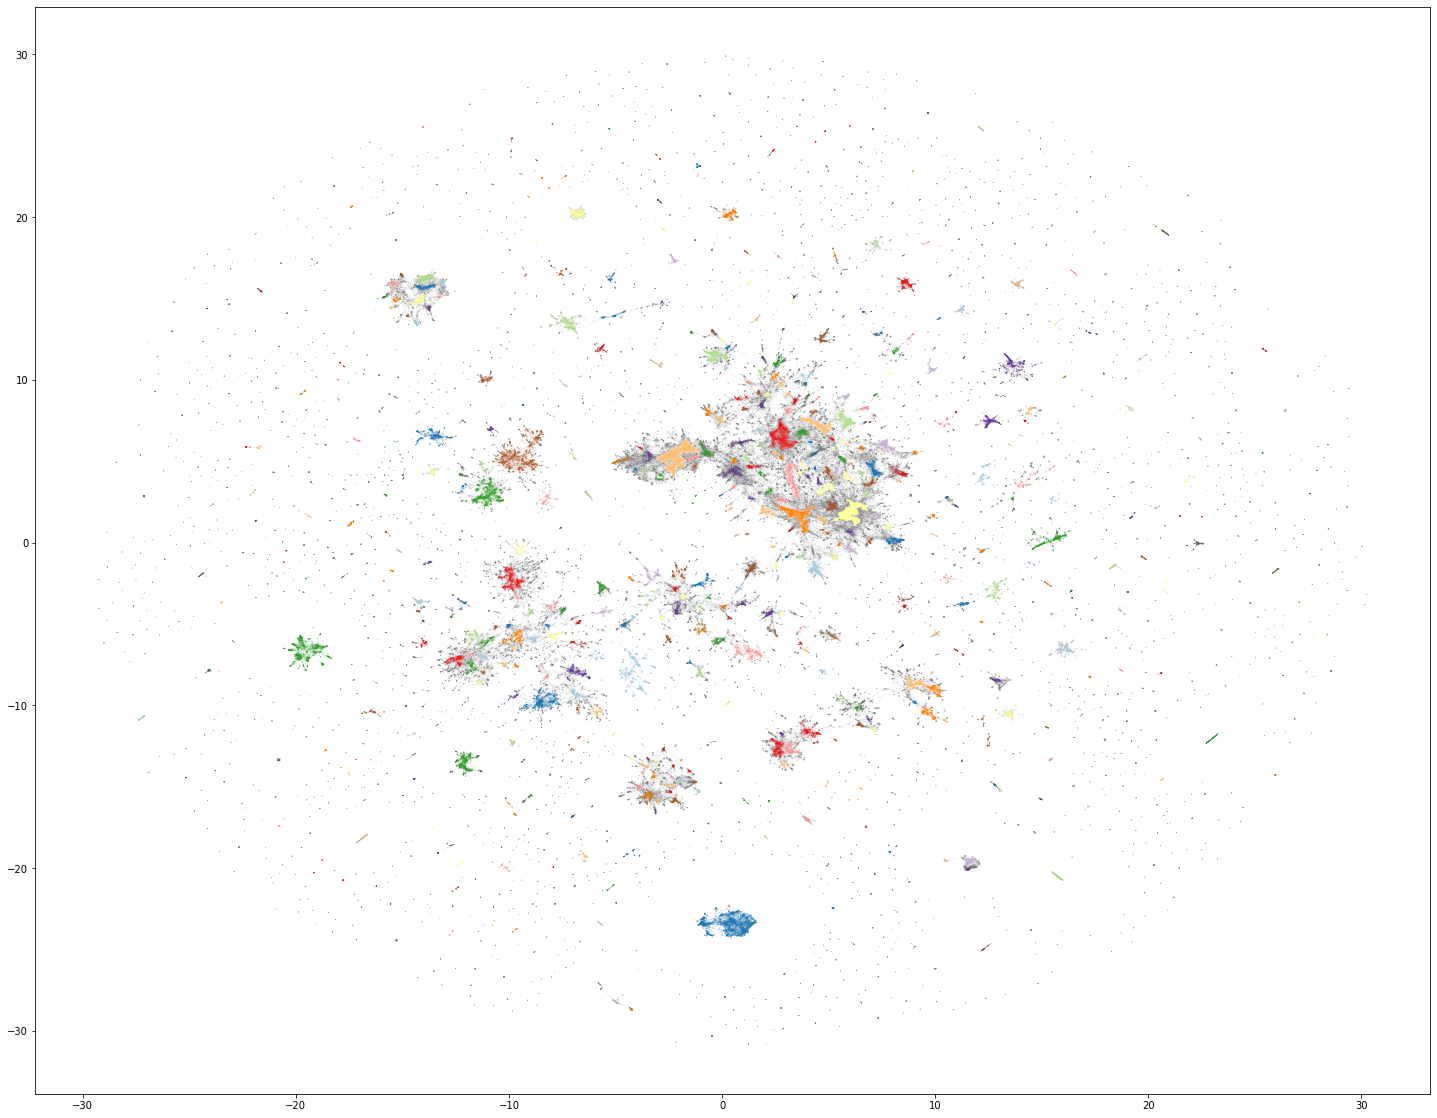

In [18]:
color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig, ax = plt.subplots(figsize=(25,20))
plt.scatter(*umap_data.T, s=0.5, linewidth=0, c=cluster_member_colors, alpha=0.25)

---

### appendix: examples from other notebooks

In [ ]:
# example of parameter tuning from another notebook

labels = {}

for EPS in [0.25, 0.5, 0.75]:
    print(f"EPS = {EPS}")
    
    dbscan_float = DBSCAN(
        eps=EPS, 
        min_samples=2,
        verbose=False,
    )
    labels[EPS] = dbscan_float.fit_predict(X)
    print(f"no clusters = {len(np.unique(labels[EPS])) - 1}")
    
    with open(f"./dbscan_cluster_idxs_EPS_{EPS}.txt", "wb") as f:
        np.savetxt(f, labels[EPS].astype(int), fmt='%i', delimiter=",")
    